In [1]:
import pandas as pd
import numpy as np
import shapefile as shp
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import pandasql as ps

pysqldf = lambda q: ps.sqldf(q, globals())


In [44]:
# full data set is about 6*10^6 rows, so we can afford to omit the ones that are missing values for any reason
        # according to FracFocus's Terms of Use agreement, any disclosures submitted with FracFocus version 1 (i.e. before 2013) will be missing data
        # so this action excludes all wells from before 2012 and some from 2013, when the version changed
naCSV = pd.read_csv("..\data\processedRegistry.csv")
regCSV = pd.read_csv("..\data\processedRegistry.csv").dropna()

# each job's disclosed chemical(s) are on their own lines
    # so, to determine how many jobs have been disclosed, keep only the first instance of that job and get rid of the rest
wellsCSV = regCSV.drop_duplicates(subset = (["APINumber", "jobYear"]), keep = "first") # subset by both APINumber and jobYear because some of the wells (identified by API number) can complete multiple jobs across different years
        
statesCts = wellsCSV["state"].value_counts().reset_index().rename(columns = {"index" : "state", "state" : "count"})
#statesCts.to_csv("statesCts.csv")

C:\Users\phoeb\AppData\Local\Temp\ipykernel_12452\16451351.py:4: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  naCSV = pd.read_csv("..\data\processedRegistry.csv")
C:\Users\phoeb\AppData\Local\Temp\ipykernel_12452\16451351.py:5: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  regCSV = pd.read_csv("..\data\processedRegistry.csv").dropna()


In [3]:
regCSV.head()

,Unnamed: 0,DisclosureId,jobYear,APINumber,state,county,op,WellName,Latitude,Longitude,depth,waterVol,nonWaterVol,CASNumber,Purpose,PercentHFJob,MassIngredient
5,5,e07e0ed2-75cd-4c0d-80bc-16211e67beda,2023.0,34067217350000,Ohio,Harrison,EAP Ohio LLC,McBride 20-11-4 10H,40.401439,-80.929303,8532.0,23901150.0,0.0,68551-12-2,Ingredient Container Purpose,0.001938,4162.920
6,6,e07e0ed2-75cd-4c0d-80bc-16211e67beda,2023.0,34067217350000,Ohio,Harrison,EAP Ohio LLC,McBride 20-11-4 10H,40.401439,-80.929303,8532.0,23901150.0,0.0,Proprietary,Ingredient Container Purpose,0.011629,24977.520
7,7,e07e0ed2-75cd-4c0d-80bc-16211e67beda,2023.0,34067217350000,Ohio,Harrison,EAP Ohio LLC,McBride 20-11-4 10H,40.401439,-80.929303,8532.0,23901150.0,0.0,104-55-2,Ingredient Container Purpose,0.000011,23.982
8,8,e07e0ed2-75cd-4c0d-80bc-16211e67beda,2023.0,34067217350000,Ohio,Harrison,EAP Ohio LLC,McBride 20-11-4 10H,40.401439,-80.929303,8532.0,23901150.0,0.0,7732-18-5,Ingredient Container Purpose,0.000015,32.331
9,9,e07e0ed2-75cd-4c0d-80bc-16211e67beda,2023.0,34067217350000,Ohio,Harrison,EAP Ohio LLC,McBride 20-11-4 10H,40.401439,-80.929303,8532.0,23901150.0,0.0,7173-51-5,Ingredient Container Purpose,0.000560,1203.177


In [4]:
yrsCts = wellsCSV["jobYear"].value_counts().reset_index().rename(columns = {"index" : "year", "jobYear" : "count"}).astype(int)
#yrsCts.to_csv("yrsCts.csv")


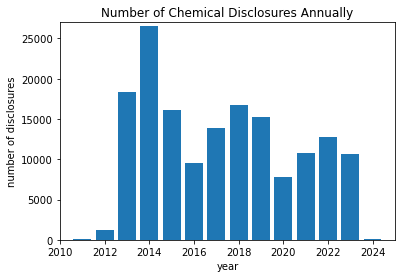

In [7]:
plt.bar(yrsCts["year"], yrsCts["count"])

plt.xlabel("year")
plt.ylabel("number of disclosures")
plt.title("Number of Chemical Disclosures Annually")

plt.ylim(0, 27000)
plt.xlim(2010, 2025)

plt.show()

In [8]:
byState = pd.DataFrame()
byState["state"] = pd.DataFrame(regCSV.groupby("state")["waterVol"])[0]
byState["minWaterVol"] = pd.DataFrame(regCSV.groupby("state")["waterVol"].min()).reset_index().iloc[:,1]
byState["maxWaterVol"] = pd.DataFrame(regCSV.groupby("state")["waterVol"].max()).reset_index().iloc[:,1]
byState["meanWaterVol"] = pd.DataFrame(regCSV.groupby("state")["waterVol"].mean()).reset_index().iloc[:,1]
byState["medianWaterVol"] = pd.DataFrame(regCSV.groupby("state")["waterVol"].median()).reset_index().iloc[:,1]

#byState.to_csv("stateAggs.csv")
byState

,state,minWaterVol,maxWaterVol,meanWaterVol,medianWaterVol
0,Alabama,5964.0,541827.0,9.173038e+04,1.000000e+05
1,Alaska,0.0,6365780.0,4.043392e+05,2.350390e+05
2,Arkansas,12726.0,16762452.0,4.886789e+06,4.725557e+06
3,California,5964.0,28156965.0,2.955930e+05,8.937200e+04
4,Colorado,0.0,199537018.0,7.343583e+06,5.540589e+06
5,Illinois,161144.0,369900.0,1.864066e+05,1.629000e+05
6,Indiana,103745.0,185673.0,1.447090e+05,1.447090e+05
7,Kansas,62.0,5619306.0,1.048309e+06,1.569960e+05
8,Kentucky,57180.0,12662688.0,2.329557e+06,9.204720e+05
9,Louisiana,0.0,65195618.8,1.644080e+07,1.441972e+07


In [9]:
# count frequency of chemicals and average amount used in a job by state

qry0 = """SELECT state, CASNumber, COUNT(CASNumber) as count, AVG(MassIngredient) AS avgAmnt
FROM (SELECT state, CASNumber, MassIngredient
      FROM regCSV)
GROUP BY CASNumber"""

chemCtsAmnt = pysqldf(qry0)

In [14]:

"""CASNumber column contains many typos and transcription errors, so we want to do 
    some tidying to get a clearer, more representitive picture of what's going on"""

chemCtsAmnt["CASNumber"] = chemCtsAmnt["CASNumber"].astype("string").str.replace("-", "")
chemCtsAmnt["CASNumber"] = chemCtsAmnt["CASNumber"].astype("string").str.replace("'", "")

# turn everything into integers and get rid of null values
chemCtsAmnt["CASNumber"] = pd.to_numeric(chemCtsAmnt["CASNumber"], errors = "coerce")
chemCtsNA = chemCtsAmnt.dropna()
chemCtsNA["CASNumber"] = chemCtsNA["CASNumber"].astype("int")

# select only entries that have valid CAS numbers (minimum 5 digits, maximum 10 digits)
qry2 = """SELECT state, CASNumber, count, avgAmnt
FROM chemCtsNA
WHERE LENGTH(CASNumber) > 4 AND LENGTH(CASNumber) < 11"""
chemCts2 = pysqldf(qry2)
        # note: some entries in CASNumber were name of them chemical so, even though the chemical was
        #   actually disclosed, it ended up ommitted from this table 


C:\Users\phoeb\AppData\Local\Temp\ipykernel_12452\1099184566.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chemCtsNA["CASNumber"] = chemCtsNA["CASNumber"].astype("int")


In [16]:
tabBase = regCSV.copy()

tabBase["CASNumber"] = tabBase["CASNumber"].str.replace("-", "")
tabBase["CASNumber"] = tabBase["CASNumber"].str.replace("'", "")

# turn everything into integers and get rid of null values
tabBase["CASNumber"] = pd.to_numeric(tabBase["CASNumber"], errors = "coerce")
tabBase = tabBase.dropna()
tabBase["CASNumber"] = tabBase["CASNumber"].astype("int") 

# select only records that contain valid CAS numbers
tabQry = """SELECT state, CASNumber
FROM tabBase
WHERE LENGTH(CASNumber) > 4 AND LENGTH(CASNumber) < 11"""
tabBaseDF = pysqldf(tabQry)
tabBaseDF


,state,CASNumber
0,Ohio,68551122
1,Ohio,104552
2,Ohio,7732185
3,Ohio,7173515
4,Ohio,107211
...,...,...
4515014,Texas,77929
4515015,Texas,7173515
4515016,Texas,111308
4515017,Texas,64175


In [19]:
### perform chi squared analysis to look for relationship between location and type of chemical used

    # H0 = There is no relationship between well location (state) and type of chemical used.
    # Ha = There is a relationship between well location and type of chemical used.
    # a = 0.05

# 1. create contingency table
conTab = pd.crosstab(index = tabBaseDF["state"], columns = tabBaseDF["CASNumber"], values = tabBaseDF["CASNumber"], aggfunc = "count", margins = True)
cT2 = conTab.fillna(0)

# 2. run analysis
res = chi2_contingency(cT2)
print("Test statistic: " + str(res[0]))
    # Test statistic: 4278957.525572649
print("p-value: " + str(res[1]))
    # p-value: 0.0
print("Degrees of freedom: " + str(res[2]))
    # Degrees of freedom: 51354

# 3. interpret results
    # p = 0.0, a = 0.05
    # p < a, therefore we reject the null hypothesis in favor of the alternative:
    # There does indeed exist a relationship between types of chemicals used and state.


Test statistic: 4278957.525572649
p-value: 0.0
Degrees of freedom: 51354


In [190]:
# perform chi-squared on chemicals based on average volume of each type of chemical and well operator

# perform string transformations to tokenize Purpose column
purp = regCSV["Purpose"].str.lower()
purp = purp.str.replace(" ", "")
    # 3511 unique values -> 2785 unique values
# export unique values and manually categorize 
    # could not be algorithmically categorized due to spelling errors, unspecific/inaccurate descriptions, etc.
# pd.DataFrame(purp.unique()).to_csv("purpp.csv")


In [193]:
purpCat = []
prp = pd.read_csv("purpp.csv").set_index("current")


for i in range(len(regCSV["Purpose"])):
    purposes = list(regCSV["Purpose"])
    cat = prp.loc[purposes[i], "replaceWith"]
    purpCat.append(cat)

    

KeyError: 'proppant,solvent,crosslinkagent,crosslinkagent,buffer,surfactant,breaker,breakercatalyst,breakercatalyst,frictionreducer,gellingagent\n'

In [194]:
len(purpCat)

5286